## Airbnb Toronto Price Prediction

### GOAL
The proposed AI-driven price prediction model aims to predict the prices of Airbnb listings in Toronto using three models: Ridge Regression, Light GBM, and Multi-layered Perceptron (Feed-forward Neural Network)

### Process
#### Data Ingestion
<li> Dataset containing listings for Toronto available via Inside Airbnb. The dataset contains 20k+ listings with 74 different characteristics.</li>

#### Initial Feature Elimination 
<li> Removed any unnecessary columns, renamed columns for better readability and converted price column to float. </li>

#### Exploratory Data Analysis (EDA)
<li> Explored various features of data to identify patterns and visualized using different graphs.</li>

#### Data Preprocessing
<li> Train-test split the data by 90-10 percentages </li>
<li> Took natural log of price </li>
<li> Handled missing values through imputation and removal depending on requirements. </li>
<li> Engineered new features such as days_since columns for host registration</li>
<li> Engineered new features for distance to downtown</li>
<li> Encoded categorical columns using boolean, ordinal and one-hot encoding depending on requirements </li>

#### Modeling and Evaluation
<li> Built 3 different models. </li>
<li>Ridge Regression with regularization </li>
<li> LightGBM with correct parameters to prevent overfitting </li>
<li> Multi-layered Perceptron (MLP) with 3 hidden layers </li>
<li> Evaluated using MSE and R2 scores </li>

#### Model Interpretation
<li> Used SHAP for local and global interpretations </li>


### Data Ingestion

In [690]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import shap
import warnings
warnings.filterwarnings('ignore')

In [691]:
# Loading airbnb data of Toronto city
airbnb_df = pd.read_csv('../dataset/Airbnb/Toronto.csv')

In [692]:
# Checking the data size
print("\nThe data size is : {} ".format(airbnb_df.shape))


The data size is : (20843, 78) 


In [693]:
# Checking dataset information
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20843 entries, 0 to 20842
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20843 non-null  int64  
 1   listing_url                                   20843 non-null  object 
 2   scrape_id                                     20843 non-null  int64  
 3   last_scraped                                  20843 non-null  object 
 4   source                                        20843 non-null  object 
 5   name                                          20843 non-null  object 
 6   description                                   20387 non-null  object 
 7   neighborhood_overview                         11112 non-null  object 
 8   picture_url                                   20843 non-null  object 
 9   host_id                                       20843 non-null 

In [694]:
# Checking what the data looks like
airbnb_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,City,distance_to_downtown,attractions_within_25km
0,1419,https://www.airbnb.com/rooms/1419,20240509032900,2024-05-09,previous scrape,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,...,NaN,f,1,1,0,0,0.06,Toronto,3.40,492
1,8077,https://www.airbnb.com/rooms/8077,20240509032900,2024-05-09,previous scrape,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,...,NaN,f,2,1,1,0,0.94,Toronto,1.47,429
2,273304,https://www.airbnb.com/rooms/273304,20240509032900,2024-05-09,previous scrape,In the heart of Toronto downtown!,NaN,NaN,https://a0.muscache.com/pictures/2756547/a098c...,1409872,...,NaN,f,1,0,1,0,NaN,Toronto,0.84,556
3,288341,https://www.airbnb.com/rooms/288341,20240509032900,2024-05-09,city scrape,Beautiful Victorian Home,"Over 3500 sqft of living. Living room, dining ...","2 min walk to Sherbourne Subway station, free ...",https://a0.muscache.com/pictures/2993294/b82cd...,1368256,...,STR-2009-GXRRPH,f,1,1,0,0,0.36,Toronto,2.10,554
4,26654,https://www.airbnb.com/rooms/26654,20240509032900,2024-05-09,city scrape,"World Class @ CN Tower, convention centre, The...","CN Tower, TIFF Bell Lightbox, Metro Convention...",There's a reason they call it the Entertainmen...,https://a0.muscache.com/pictures/81811785/5dcd...,113345,...,NaN,f,5,5,0,0,0.26,Toronto,0.98,452


In [695]:
# Checking for null values in the dataset
airbnb_df.isnull().sum().sort_values(ascending=False)

calendar_updated                20843
neighbourhood_group_cleansed    20843
host_neighbourhood              12517
host_about                      11104
license                         10943
                                ...  
minimum_maximum_nights              0
maximum_maximum_nights              0
minimum_nights_avg_ntm              0
maximum_nights_avg_ntm              0
attractions_within_25km             0
Length: 78, dtype: int64

### Initial Feature Elimination

First, we manually eliminated some features that were unnecessary. The features removed were listing_url,amenities,host_verifications,reviews ,scrape_id, last_scraped, source, host_url, host_thumbnail_url, host_picture_url, calendar_updated, and calendar_last_scraped.

Secondly, we eliminate many location-related and listing count related columns since many of them are duplicated, and are mostly filled with null values.

Thirdly, we eliminate redundant columns.

Finally, eliminating columns after model interpretability and tuning the model

In [696]:
feature_elimination_list = ['amenities','host_verifications','listing_url','attractions_within_25km', 'City','scrape_id', 'last_scraped', 'source', 'host_url', 'host_thumbnail_url', 'calendar_updated', 'calendar_last_scraped', 'host_name', 'id', 'host_id', 'neighbourhood_group_cleansed', 'host_neighbourhood', 'host_location', 'neighbourhood','neighbourhood_cleansed', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'review_scores_accuracy', 'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'host_about', 'neighborhood_overview', 'host_has_profile_pic', 'picture_url', 'host_picture_url', 'calculated_host_listings_count', 'number_of_reviews']

airbnb_df = airbnb_df.drop(feature_elimination_list, axis=1)

### Renaming Columns

In [697]:
# Mapping new column names
column_mappings = {
    'name': 'title',
    'first_review': 'first_review_date',
    'last_review': 'last_review_date',
    'review_scores_value': 'review_scores_value_for_money'
}

# Renaming columns
airbnb_df.rename(columns=column_mappings, inplace=True)

Converting price to integer

In [698]:
# Removing "$" from price and converting to float
# print(airbnb_df['price'].dtype)
airbnb_df['price'] = airbnb_df['price'].str.replace('[$,]', '', regex=True).astype(float)

### EDA

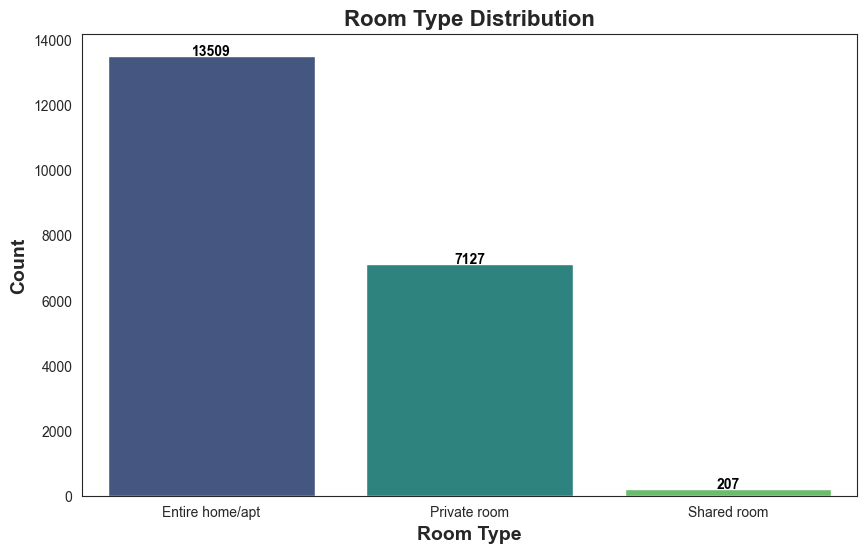

In [699]:
# Create the figure
plt.figure(figsize=(10, 6))

# Get the room type counts
room_type_counts = airbnb_df['room_type'].value_counts()

# Create the bar plot with a color palette
bar_plot = sns.barplot(x=room_type_counts.index, y=room_type_counts.values, palette="viridis")

# Add labels to each bar
for index, value in enumerate(room_type_counts.values):
    bar_plot.text(index, value + 10, str(value), color='black', ha="center", fontweight='bold')

# Customize the title and axis labels
plt.title('Room Type Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Room Type', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')


# Show the plot
plt.show()

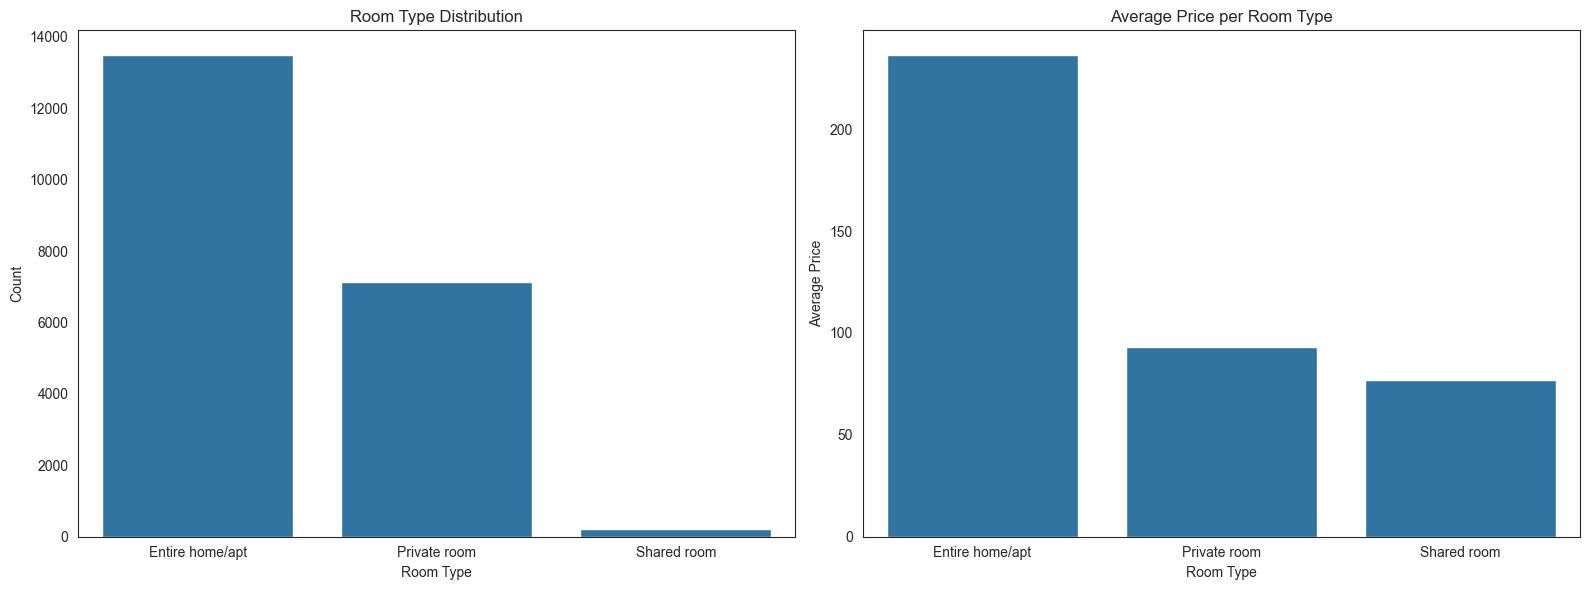

In [700]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
 
# Plot Room Type Distribution
room_type_counts = airbnb_df['room_type'].value_counts()
sns.barplot(x=room_type_counts.index, y=room_type_counts.values, ax=ax[0])
ax[0].set_title('Room Type Distribution')
ax[0].set_xlabel('Room Type')
ax[0].set_ylabel('Count')
 
# Plot Average Price per Room Type
avg_price_per_room = airbnb_df.groupby('room_type')['price'].mean().reset_index()
sns.barplot(x='room_type', y='price', data=avg_price_per_room, ax=ax[1])
ax[1].set_title('Average Price per Room Type')
ax[1].set_xlabel('Room Type')
ax[1].set_ylabel('Average Price')
 
# Show the plots
plt.tight_layout()
plt.show()

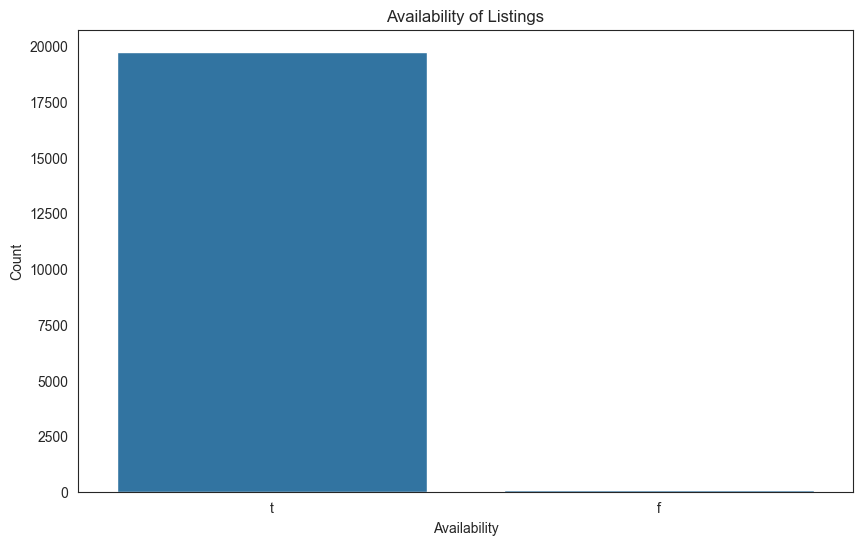

In [701]:
plt.figure(figsize=(10, 6))
sns.set_style("white")
availability_counts = airbnb_df['has_availability'].value_counts()
sns.barplot(x=availability_counts.index, y=availability_counts.values)
plt.title('Availability of Listings')
plt.xlabel('Availability')
plt.ylabel('Count')
plt.show()

In [702]:
availability_counts = airbnb_df['has_availability'].value_counts()
availability_counts

has_availability
t    19752
f       61
Name: count, dtype: int64

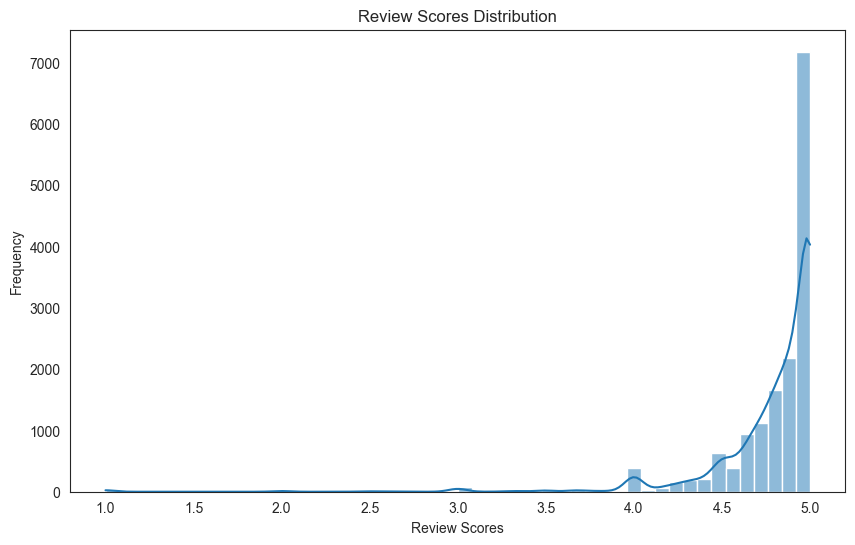

In [703]:
# Review Scores Distribution
plt.figure(figsize=(10, 6))
sns.histplot(airbnb_df['review_scores_rating'], bins=50, kde=True)
plt.title('Review Scores Distribution')
plt.xlabel('Review Scores')
plt.ylabel('Frequency')
plt.show()

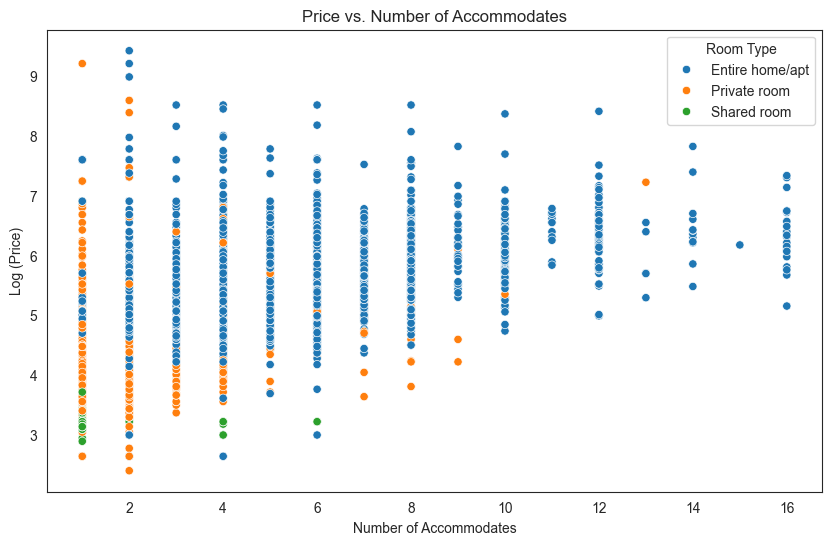

In [704]:
# Relationship between the price and the number of reviews.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accommodates', y=np.log(airbnb_df['price']), data=airbnb_df, hue='room_type')
plt.title('Price vs. Number of Accommodates')
plt.xlabel('Number of Accommodates')
plt.ylabel('Log (Price)')
plt.legend(title='Room Type')
plt.show()

### Train-Test Split

In [705]:
# Splitting the data to training and testing sets 90/10
data_train, data_test = train_test_split(airbnb_df, test_size=0.10, random_state=42)

In [706]:
# Checking the data size
print("\nThe train data size is : {} ".format(data_train.shape))
print("The test data size is : {} ".format(data_test.shape))


The train data size is : (18758, 35) 
The test data size is : (2085, 35) 


### Data Preprocessing

In [707]:
# Checking what the data looks like
data_train.head()

,title,description,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,latitude,longitude,...,last_review_date,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value_for_money,license,instant_bookable,distance_to_downtown
16586,Spacious 4-Bed Retreat near Guildwood GO Stati...,"This 4 bed, 3 bath home is perfectly equipped ...",2023-10-10,within an hour,100%,82%,t,t,43.749601,-79.195725,...,2024-04-29,5.00,4.75,5.00,5.00,5.00,4.88,STR-2308-GCZKVS,f,18.49
13084,"DT Toronto,Spacious Master Suite|NETFLIX|KEURIG",Welcome! Discover our newly renovated Edwardia...,2017-07-21,within an hour,100%,97%,t,t,43.665917,-79.368768,...,2024-04-28,4.98,4.98,4.98,4.98,4.90,4.94,STR-2303-JGYXVZ,f,1.83
3375,Beautiful Artist Flat Steps To Trendy Queen West,"*Featured in Handmade Hotels TV series, airing...",2015-02-17,NaN,NaN,NaN,f,t,43.643370,-79.434170,...,2020-03-28,4.87,4.87,4.93,4.99,4.93,4.73,NaN,f,4.24
19238,Centrally Located Lux Toronto Home,"A centrally located home, newly renovated and ...",2012-02-09,within a few hours,100%,0%,f,t,43.662680,-79.403790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STR-2402-HFXHHW,f,1.96
20457,Master Suite Close to UTSC/Centennial College,Welcome to My Home! Located in a quiet neighbo...,2022-08-03,within an hour,100%,92%,t,t,43.790510,-79.186030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,22.00


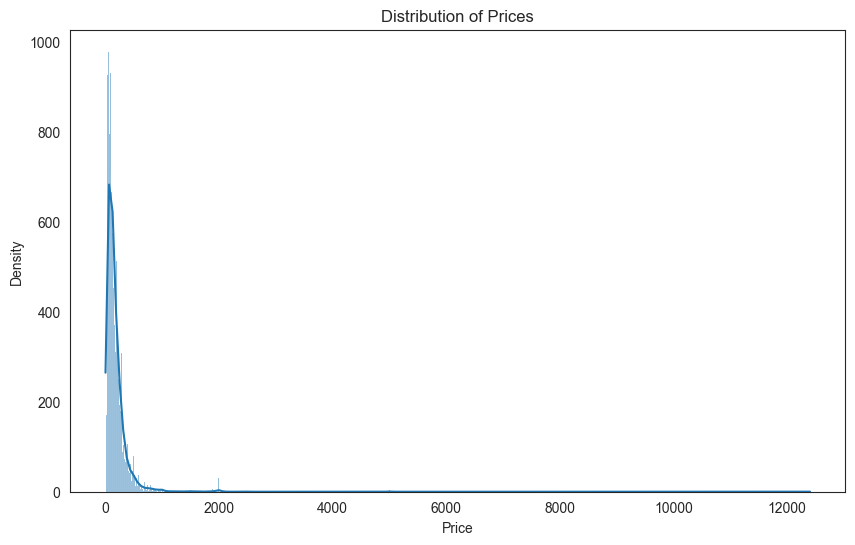

In [708]:
# Plotting a histogram of target variable
plt.figure(figsize=(10,6))
sns.histplot(data_train['price'], kde=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Prices')
plt.show()

The prices for the listings in the dataset are greatly skewed to the right as shown above. This causes a non-linear relationship between the price and features.

To solve this issue, we take the natural logarithm of the price to make the effective relationship non-linear, while still preserving the linear model. This will be very important when testing different regression models. The results of this are shown below.

In [709]:
# Converting values in price column to its natural logarithm
data_train['price'] = np.log(data_train['price'])

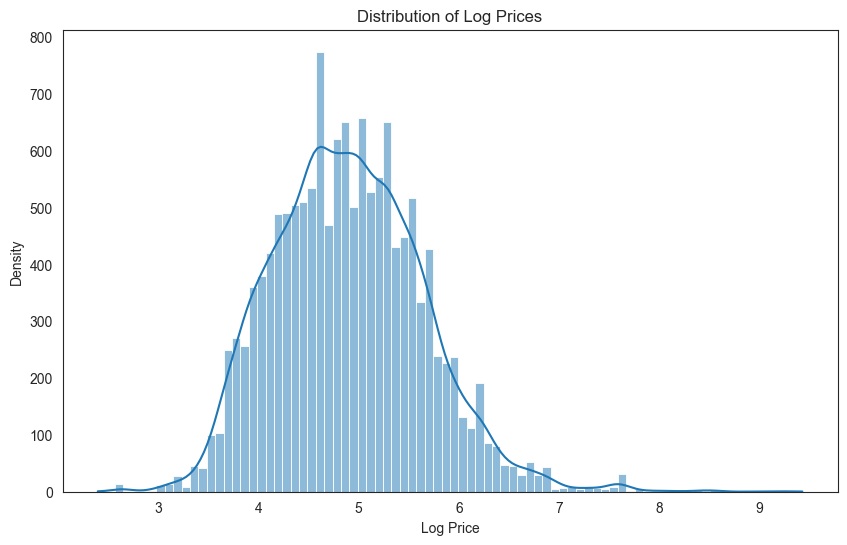

In [710]:
# Plotting a histogram of the log of price
plt.figure(figsize=(10,6))
sns.histplot(data_train['price'], kde=True)
plt.xlabel('Log Price')
plt.ylabel('Density')
plt.title('Distribution of Log Prices')
plt.show()

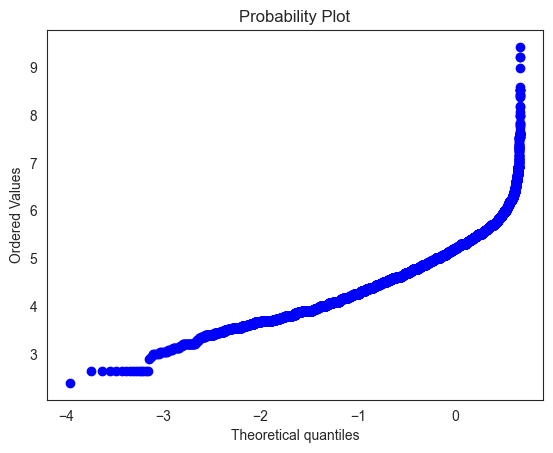

In [711]:
# The QQ-plot
fig = plt.figure()
res = stats.probplot(data_train['price'], plot=plt)
plt.show()

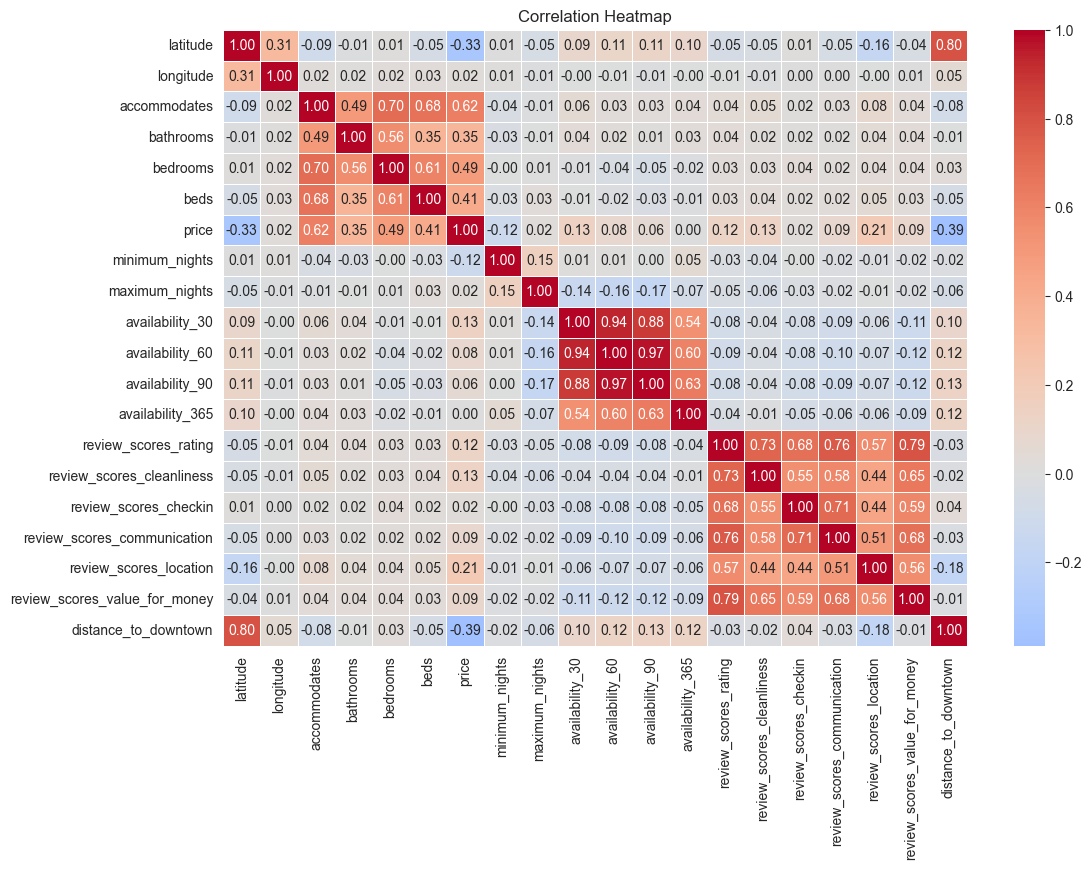

In [712]:
# Identify and drop non-numeric columns
non_numeric_columns = data_train.select_dtypes(include=['object']).columns
data_train_numeric = data_train.drop(non_numeric_columns, axis=1)

corr_mx = data_train_numeric.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))  # Adjust the figsize to your preference
sns.heatmap(corr_mx, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)

# Set the title
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

### Handling Missing Values

In [713]:
# Checking for null values in the dataset
data_train.isnull().sum().sort_values(ascending=False)

license                          9887
host_response_time               5572
host_response_rate               5572
review_scores_location           4934
review_scores_value_for_money    4933
review_scores_checkin            4933
review_scores_communication      4933
review_scores_cleanliness        4932
review_scores_rating             4910
first_review_date                4910
last_review_date                 4910
host_acceptance_rate             4867
beds                             4732
bathrooms                        4715
price                            4712
bedrooms                         1350
has_availability                  908
description                       406
host_is_superhost                 351
host_identity_verified              2
host_since                          2
instant_bookable                    0
title                               0
minimum_nights                      0
availability_365                    0
availability_90                     0
availability

The null in license column means that the listing doesn't have any license, so filled the column with said information.

In [714]:
# Fill null value with unlicensed
data_train['license'].fillna('Unlicensed', inplace=True)

Dropping all rows that don't have price because it doesn't help the model if it is filled in any way to make correct predictions

In [715]:
# Drop rows with empty price
data_train = data_train.dropna(subset=['price'])

Dropping records with null reviews so that we have more accurate prediction

In [716]:
data_train = data_train.dropna(subset=['review_scores_rating'])

Similarly, filling null values in first and last review dates with today's date where review count is 0. This will be important during data encoding.

Filling null values in host_is_superhost and 'availability' with "f" since the missing values are not random, and just corresponds to none.

In [717]:
data_train['host_is_superhost'] = data_train['host_is_superhost'].fillna('f')
data_train['has_availability'] = data_train['has_availability'].fillna('f')

Filling null values in host_response_time to mode of the feature

In [718]:
data_train['host_response_time'] = data_train['host_response_time'].fillna(data_train['host_response_time'].mode()[0])

Filling null values in remaining columns with median

In [719]:
# Remove % sign and convert to numeric for the following columns
data_train['host_response_rate'] = pd.to_numeric(data_train['host_response_rate'].str.replace('%', ''))
data_train['host_acceptance_rate'] = pd.to_numeric(data_train['host_acceptance_rate'].str.replace('%', ''))

# Creating a list of required columns
numeric_columns = [
    'host_response_rate',
    'host_acceptance_rate',
    'bedrooms', 'beds', 
    'review_scores_value_for_money', 
    'review_scores_location', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_cleanliness', 
    'bathrooms'
]

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_train[column].median()
    data_train[column].fillna(median_value, inplace=True)   

In [720]:
# Rechecking null values
data_train.isnull().sum().sort_values(ascending=False)

description                      98
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
first_review_date                 0
last_review_date                  0
title                             0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value_for_money     0
license                           0
instant_bookable                  0
review_scores_rating              0
minimum_nights                    0
price                             0
beds                              0
bedrooms                          0
bathrooms                         0
accommodates                      0
room_type                         0
property_type                     0
longitude                         0
latitude                    

We will clean up the description field during data encoding.

In [721]:
# Checking the data size
print("\nThe train data size is : {} ".format(data_train.shape))


The train data size is : (10581, 35) 


## Feature Engineering

### Feature Extraction

##### Adding days since columns using the date columns

In [722]:
current_date = datetime.now()

# Converting date columns
data_train['host_since'] = pd.to_datetime(data_train['host_since'])

# Calculating values and storing in a new column
data_train['host_since_days'] = (current_date - data_train['host_since']).dt.days

# Dropping date columns
data_train.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

In [723]:
# Define downtown coordinates for Toronto city
downtown_coords = (43.6532, -79.3832) 

In [724]:
# Defining haversine distance function to calculate distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [725]:
# Calculate distance to downtown using broadcasting
lat, lon = downtown_coords

# Calculate the distance to downtown for each entry in the dataset
data_train['distance_to_downtown'] = data_train.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], lat, lon), axis=1
)

### Data Encoding

In [726]:
# Selecting non numerical columns from the dataframe
non_numerical_columns = data_train.select_dtypes(exclude=['number']).columns.tolist()
categorical_columns = data_train[non_numerical_columns]

categorical_columns.head()

,title,description,host_response_time,host_is_superhost,host_identity_verified,property_type,room_type,has_availability,license,instant_bookable
16586,Spacious 4-Bed Retreat near Guildwood GO Stati...,"This 4 bed, 3 bath home is perfectly equipped ...",within an hour,t,t,Entire home,Entire home/apt,t,STR-2308-GCZKVS,f
13084,"DT Toronto,Spacious Master Suite|NETFLIX|KEURIG",Welcome! Discover our newly renovated Edwardia...,within an hour,t,t,Private room in home,Private room,t,STR-2303-JGYXVZ,f
11793,Contemporary room in Art House,Welcome to Art House on Queen West. A home des...,within an hour,f,t,Private room in townhouse,Private room,t,STR-2302-JBXRVZ,f
11843,Private room w/4 piece bath,The large room is decorated in a comfortable a...,within an hour,t,t,Private room in townhouse,Private room,t,Unlicensed,f
17974,East Downtown Bachelor Unit with Paid Parking,A studio unit on the basement floor. There is ...,within an hour,t,t,Entire rental unit,Entire home/apt,t,Unlicensed,f


Converting boolean columns and picture url columns to 0s and 1s

In [727]:
for boolean_column in ['host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_train[boolean_column] = data_train[boolean_column].map(lambda s: False if s == "f" else True)

Changing data in license column to licensed and unlicensed and converting to boolean

In [728]:
# Changing data
data_train['license'] = data_train['license'].map(lambda s: False if s == "Unlicensed" else True)

Ordinal Encoding host_response_time since there is a clear order

In [729]:
# Define the order of categories
categories = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

# Initialize OrdinalEncoder with the defined categories
ordinal_encoder = OrdinalEncoder(categories=[categories])

# Fit and transform the 'host_response_time' column
data_train['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_train[['host_response_time']])

# Dropping the categorical column
data_train.drop(columns=['host_response_time'], inplace=True)

One hot encoding property_type, city, and room_type 

We are one-hot encoding these columns, but keeping the original because Light GBM inherently supports categorical columns. We will handle the features for different models during feature selection.

In [730]:
# Create the dummy variables without dropping the original column
dummy_vars_tp = pd.get_dummies(data_train['property_type'], prefix='property')
# Concatenate the original DataFrame with the dummy variables
data_train = pd.concat([data_train, dummy_vars_tp], axis=1)

# Create the dummy variables without dropping the original column
dummy_vars_tr = pd.get_dummies(data_train['room_type'], prefix='room_type')
# Concatenate the original DataFrame with the dummy variables
data_train = pd.concat([data_train, dummy_vars_tr], axis=1)

### Feature Extraction

##### Sentiment Analysis of Title and Description 

In [731]:
# Need to download once for sentiment analysis
# nltk.download('vader_lexicon')

#creating an object of sentiment intensity analyzer
sia= SentimentIntensityAnalyzer()

# creating new columns using polarity scores function
data_train['title_scores'] = data_train['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_train['title_sentiment']=data_train['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_train.drop(['title', 'title_scores'], axis=1, inplace=True)


# creating new columns using polarity scores function
data_train['description_scores']=data_train['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_train['description_sentiment']=data_train['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_train.drop(['description', 'description_scores'], axis=1, inplace=True)

In [732]:
data_train.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,property_Shared room in hotel,property_Shared room in rental unit,property_Shared room in townhouse,property_Shipping container,property_Tiny home,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,title_sentiment,description_sentiment
16586,100.0,82.0,True,True,43.749601,-79.195725,Entire home,Entire home/apt,7,3.0,...,False,False,False,False,False,True,False,False,0.2023,0.9230
13084,100.0,97.0,True,True,43.665917,-79.368768,Private room in home,Private room,2,1.0,...,False,False,False,False,False,False,True,False,0.0000,0.9296
11793,94.0,68.0,False,True,43.648180,-79.409360,Private room in townhouse,Private room,1,1.0,...,False,False,False,False,False,False,True,False,0.0000,0.7469
11843,100.0,91.0,True,True,43.700810,-79.445042,Private room in townhouse,Private room,1,1.0,...,False,False,False,False,False,False,True,False,0.0000,0.8519
17974,100.0,74.0,True,True,43.666770,-79.350500,Entire rental unit,Entire home/apt,2,1.0,...,False,False,False,False,False,True,False,False,0.0000,0.1531


#### Feature Selection

In [733]:
train_features = data_train.copy()

In [734]:
for col in train_features.columns[train_features.isnull().any()]:
    print(col)
else:
    print("No null values!")

No null values!


#### Replicating all the adjustments we have made to testing dataset

Data Preprocessing

In [735]:
# Converting values in price column to its natural logarithm
data_test['price'] = np.log(data_test['price'])


In [736]:
# Fill null value with unlicensed
data_test['license'].fillna('Unlicensed', inplace=True)

# Drop rows with empty price and review score
data_test = data_test.dropna(subset=['price'])
data_test = data_test.dropna(subset=['review_scores_rating'])

# Fill null in host related columns
data_test['host_is_superhost'] = data_test['host_is_superhost'].fillna('f')
data_test['has_availability'] = data_test['has_availability'].fillna('f')
data_test['host_response_time'] = data_test['host_response_time'].fillna(data_test['host_response_time'].mode()[0])

# Remove % sign and convert to numeric for the following columns
data_test['host_response_rate'] = pd.to_numeric(data_test['host_response_rate'].str.replace('%', ''))
data_test['host_acceptance_rate'] = pd.to_numeric(data_test['host_acceptance_rate'].str.replace('%', ''))

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_test[column].median()
    data_test[column].fillna(median_value, inplace=True)

Feature Extraction

In [737]:
# Adding days since columns
# Converting date columns
data_test['host_since'] = pd.to_datetime(data_test['host_since'])

# Calculating values and storing in a new column
data_test['host_since_days'] = (current_date - data_test['host_since']).dt.days

# Dropping date columns
data_test.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

In [738]:
# Calculate the distance to downtown for each entry in the dataset
data_test['distance_to_downtown'] = data_test.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], lat, lon), axis=1
)

Data Encoding

In [739]:
# Converting boolean columns and picture url columns to 0s and 1s
for boolean_column in ['host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_test[boolean_column] = data_test[boolean_column].map(lambda s: False if s == "f" else True)

In [740]:
# Changing data in license column to licensed and unlicensed and converting to boolean
data_test['license'] = data_test['license'].map(lambda s: False if s == "Unlicensed" else True)

# Ordinal Encoding host_response_time since there is a clear order
data_test['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_test[['host_response_time']])
data_test.drop(columns=['host_response_time'], inplace=True)

In [741]:
# Create the dummy variables without dropping the original column
dummy_test_vars = pd.get_dummies(data_test['property_type'], prefix='property')
# Aligning the columns in data_test to match those in data_train
dummy_test_vars = dummy_test_vars.reindex(columns=dummy_vars_tp.columns, fill_value=0)
# Concatenate the original DataFrame with the dummy variables
data_test = pd.concat([data_test, dummy_test_vars], axis=1)

# Create the dummy variables without dropping the original column
dummy_test_vars = pd.get_dummies(data_test['room_type'], prefix='room_type')
# Aligning the columns in data_test to match those in data_train
dummy_test_vars = dummy_test_vars.reindex(columns=dummy_vars_tr.columns, fill_value=0)
# Concatenate the original DataFrame with the dummy variables
data_test = pd.concat([data_test, dummy_test_vars], axis=1)

In [742]:
# Sentiment Scores

# creating new columns using polarity scores function
data_test['title_scores'] = data_test['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_test['title_sentiment']=data_test['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_test.drop(['title', 'title_scores'], axis=1, inplace=True)

# creating new columns using polarity scores function
data_test['description_scores']=data_test['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_test['description_sentiment']=data_test['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_test.drop(['description', 'description_scores'], axis=1, inplace=True)

Feature Selection

In [743]:
test_features = data_test.copy()
for col in test_features.columns[test_features.isnull().any()]:
    print(col)
else:
    print("No null values!")

No null values!


### Data Preparation

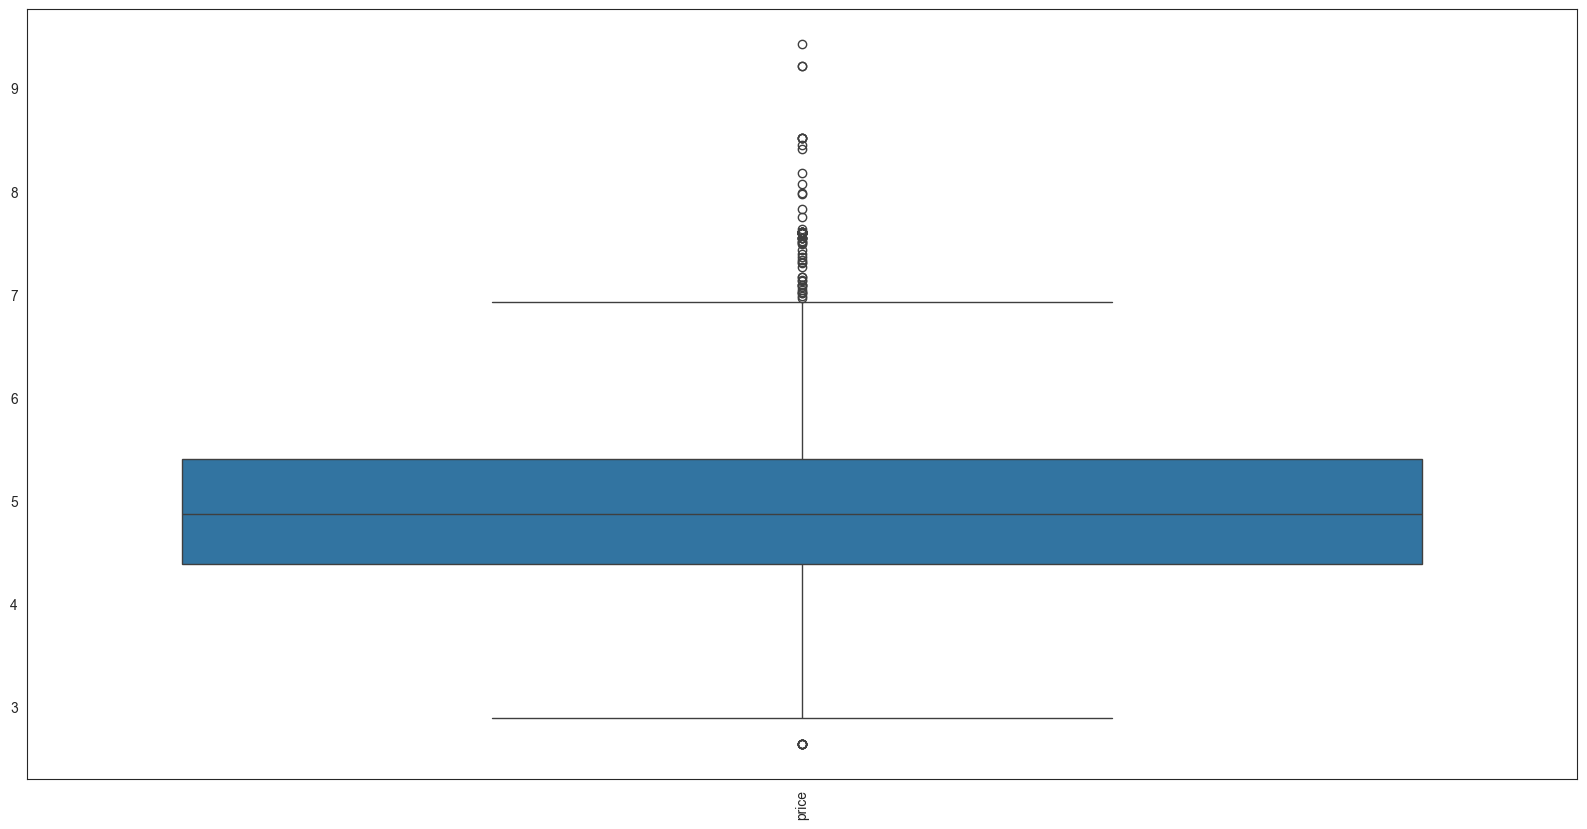

In [744]:
# Checking for outliers in price
plt.figure(figsize=(20,10))
sns.boxplot(data=train_features[['price']])
plt.xticks(rotation=90)
plt.show()

Removing or not removing the outliers doesn't change the output much, meaning the models are well equipped to handle outliers

In [745]:
#Handling Outliers using median and IQR 
def outlier(a):
    Q1 = a.quantile(0.25)
    Q3 = a.quantile(0.75)
    IQR = Q3-Q1
    L = Q1 - 1.5*IQR
    U = Q3 + 1.5*IQR
    return(L,U)

# # Updating price
train_features = train_features.loc[train_features['price'] >= outlier(train_features['price'])[0]]
train_features = train_features.loc[train_features['price'] <= outlier(train_features['price'])[1]]

test_features = test_features.loc[test_features['price'] >= outlier(test_features['price'])[0]]
test_features = test_features.loc[test_features['price'] <= outlier(test_features['price'])[1]]

#### Feature and Target selection for different models

In [746]:
# Drop encoded columns for LightGBM
# Identify columns to drop using regex
cols_to_drop = train_features.filter(regex='^(property_(?!type$)|room_type_)').columns

# Drop the identified columns from train and test
X_train_selected = train_features.drop(columns=cols_to_drop)
X_train_selected = X_train_selected.drop(['price'], axis=1)
X_test_selected = test_features.drop(columns=cols_to_drop)
X_test_selected = X_test_selected.drop(['price'], axis=1)

# Drop categorical columns for other models
X_train = train_features.drop(columns=['price', 'property_type', 'room_type'])
X_test = test_features.drop(columns=['price', 'property_type', 'room_type'])

# Aligning column discrepancy, if any
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

# Selecting target for train and test
y_train = train_features['price']
y_test = test_features['price']

X_train_selected.shape, X_test_selected.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10500, 32), (1166, 32), (10500, 80), (1166, 80), (10500,), (1166,))

## Model Building

In [747]:
# Feature Scaling for Ridge Regression and MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Ridge

In [748]:
# Ridge Regression
model_ridge = Ridge(alpha=0.001, random_state=42)
model_ridge.fit(X_train_scaled, y_train)

# Predicting the price
train_pred_ridge = model_ridge.predict(X_train_scaled)
test_pred_ridge = model_ridge.predict(X_test_scaled)

# Evaluate Ridge Regression
r_train_r2 = r2_score(y_train, train_pred_ridge)
r_train_mse = mean_squared_error(y_train, train_pred_ridge)
r_test_r2 = r2_score(y_test, test_pred_ridge)
r_test_mse = mean_squared_error(y_test, test_pred_ridge)

# Printing the evaluation metrices values
print(f'\n--------Ridge Regression Train Fitting-----------')
print(f'R2 Score: {r_train_r2}')
print(f'MSE: {r_train_mse}')
print(f'--------Ridge Regression Test Fitting-----------')
print(f'R2 Score: {r_test_r2}')
print(f'MSE: {r_test_mse}')


--------Ridge Regression Train Fitting-----------
R2 Score: 0.7109661694186071
MSE: 0.13959411220698079
--------Ridge Regression Test Fitting-----------
R2 Score: 0.7130559510779547
MSE: 0.12322050112583026


##### Light GBM

In [749]:
# Build the model
# Identified ideal parameters to prevent overfitting
model_lgbm = lgb.LGBMRegressor(max_bin=100, learning_rate=0.01, n_estimators=365, num_leaves=50, verbose=0,
                               max_depth=-1, random_state=42)

# Encode categorical features
categorical_features = ['property_type', 'room_type']
for col in categorical_features:
    X_train_selected[col] = X_train_selected[col].astype('category')
    X_test_selected[col] = X_test_selected[col].astype('category')

# Convert categorical features to their indices
categorical_feature_indices = [X_train_selected.columns.get_loc(col) for col in categorical_features]

model_lgbm.fit(X_train_selected, y_train, categorical_feature=categorical_feature_indices)
train_pred_lgbm = model_lgbm.predict(X_train_selected)
test_pred_lgbm = model_lgbm.predict(X_test_selected)

# Evaluate Light GBM
lgbm_train_r2 = r2_score(y_train, train_pred_lgbm)
lgbm_train_mse = mean_squared_error(y_train, train_pred_lgbm)
lgbm_test_r2 = r2_score(y_test, test_pred_lgbm)
lgbm_test_mse = mean_squared_error(y_test, test_pred_lgbm)

# Calculating and printing the evaluation metrices values
print(f'\n--------Tuned Light GBM Train Fitting-----------')
print(f'R2 Score: {lgbm_train_r2}')
print(f'MSE: {lgbm_train_mse}')
print(f'--------Tuned Light GBM Test Fitting-----------')
print(f'R2 Score: {lgbm_test_r2}')
print(f'MSE: {lgbm_test_mse}')

r2_difference = lgbm_train_r2 - lgbm_test_r2
mse_difference = lgbm_train_mse - lgbm_test_mse
print(f'Difference in R2 Score: {r2_difference}')
print(f'Difference in MSE: {mse_difference}')


--------Tuned Light GBM Train Fitting-----------
R2 Score: 0.8180174706102772
MSE: 0.08789175155115757
--------Tuned Light GBM Test Fitting-----------
R2 Score: 0.7684249258165641
MSE: 0.09944376541813697
Difference in R2 Score: 0.04959254479371311
Difference in MSE: -0.011552013866979405


##### MLP

In [750]:
# Define the MLP model
model_mlp = Sequential()

# Input Layer and First Hidden Layer
model_mlp.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model_mlp.add(Dropout(0.3))

# Second Hidden Layer
model_mlp.add(Dense(64, activation='relu'))

# Third Hidden Layer
model_mlp.add(Dense(32, activation='relu'))

# Output Layer
model_mlp.add(Dense(1, activation='linear'))

# Compile the model
model_mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Implement early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model_mlp.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=-1)

# Predicting the price
train_pred_mlp = model_mlp.predict(X_train_scaled)
test_pred_mlp = model_mlp.predict(X_test_scaled)

# Evaluate MLP
m_train_r2 = r2_score(y_train, train_pred_mlp)
m_train_mse = mean_squared_error(y_train, train_pred_mlp)
m_test_r2 = r2_score(y_test, test_pred_mlp)
m_test_mse = mean_squared_error(y_test, test_pred_mlp)

# Calculating and printing the evaluation metrices values
print(f'\n--------MLP Train Fitting-----------')
print(f'R2 Score: {m_train_r2}')
print(f'MSE: {m_train_mse}')

print(f'--------MLP Test Fitting-----------')
print(f'R2 Score: {m_test_r2}')
print(f'MSE: {m_test_mse}')

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

#### Comparing the performance of different models

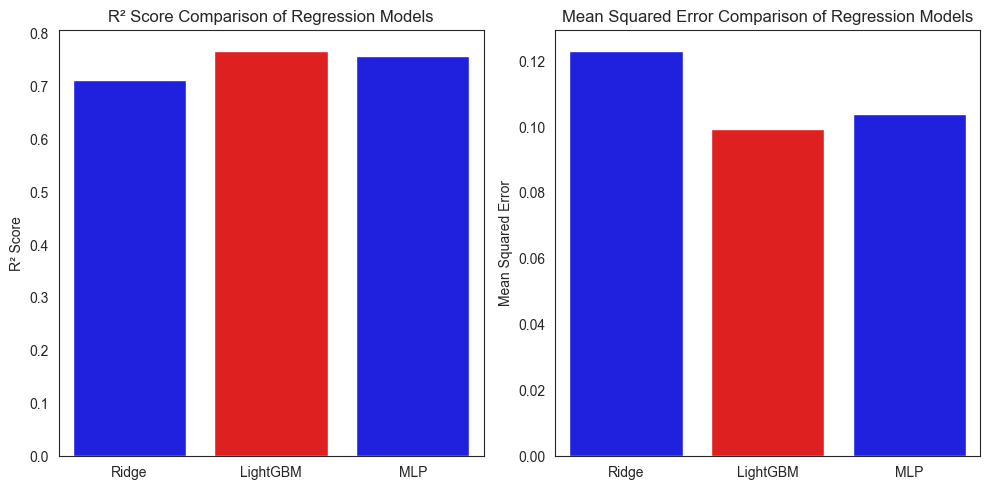

R² Scores:
      Model  R² Score
0     Ridge  0.713056
1  LightGBM  0.768425
2       MLP  0.758207

Mean Squared Errors:
      Model       MSE
0     Ridge  0.123221
1  LightGBM  0.099444
2       MLP  0.103832


In [751]:
# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Model': [ 'Ridge', 'LightGBM', 'MLP'],
    'R² Score': [r_test_r2, lgbm_test_r2, m_test_r2],
    'MSE': [r_test_mse, lgbm_test_mse, m_test_mse]
})

# Find the index of the highest R² score and lowest MSE
best_r2_idx = results_df['R² Score'].idxmax()
best_mse_idx = results_df['MSE'].idxmin()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot R² scores with custom colors
palette_r2 = ['red' if i == best_r2_idx else 'blue' for i in range(len(results_df))]
sns.barplot(ax=axes[0], x='Model', y='R² Score', data=results_df, palette=palette_r2)
axes[0].set_title('R² Score Comparison of Regression Models')
axes[0].set_xlabel('')
axes[0].set_ylabel('R² Score')

# Plot MSE with custom colors
palette_mse = ['red' if i == best_mse_idx else 'blue' for i in range(len(results_df))]
sns.barplot(ax=axes[1], x='Model', y='MSE', data=results_df, palette=palette_mse)
axes[1].set_title('Mean Squared Error Comparison of Regression Models')
axes[1].set_xlabel('')
axes[1].set_ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

# Print the results for quick reference
print("R² Scores:")
print(results_df[['Model', 'R² Score']])

print("\nMean Squared Errors:")
print(results_df[['Model', 'MSE']])

## Model Tuning

Identifying the predictions that have the highest residuals.

In [752]:
# Calculate residuals
residuals = test_pred_lgbm - y_test

# Calculate absolute residuals
abs_residuals = np.abs(residuals)

# Create a dataframe with actual, predicted prices, and residuals
results_df = pd.DataFrame({
    'actual_price': y_test,
    'predicted_price': test_pred_lgbm,
    'residual': residuals,
    'absolute_residual': abs_residuals
})

# Add an auto-incrementing index column starting from 0
results_df['row_number'] = range(len(results_df))

# Sort the dataframe by absolute residuals in descending order
sorted_results_df = results_df.sort_values(by='absolute_residual', ascending=False)

print("Top 10 most incorrect predictions:")
sorted_results_df.head(10)

Top 10 most incorrect predictions:


,actual_price,predicted_price,residual,absolute_residual,row_number
7215,6.551080,4.601919,-1.949162,1.949162,417
6662,6.380123,5.172972,-1.207151,1.207151,870
2585,4.174387,5.356567,1.182180,1.182180,1120
4902,6.472346,5.306904,-1.165442,1.165442,523
13322,4.219508,5.296567,1.077059,1.077059,501
326,3.891820,4.949950,1.058129,1.058129,673
649,5.010635,3.969750,-1.040885,1.040885,33
17146,5.768321,4.729929,-1.038392,1.038392,199
17147,5.913503,4.880183,-1.033320,1.033320,222
2516,6.214608,5.209518,-1.005091,1.005091,209


In [753]:
# Stacking features and target for interpretability
test = [X_test_selected, y_test]

Using SHAP to interpret the model

In [754]:
# Creating a function to calculate SHAP values and display visualization based on provided parameters

def XAI_SHAP(model, data, graph, obs=0):
    """ Computes SHAP values and represents XAI graphs

    - Parameters:
        - model = Machine Learning model to interpret
        - data = Data used to make explanations
        - graph = Global or local interpretation
        - obs = Index of data instance to explain

    - Output:
        - XAI graphs and SHAP values
    """
    # Print JavaScript visualizations
    shap.initjs()

    # Create object to calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(data)
    
    if graph == 'global':
        # Global Interpretability (feature importance)
        shap.plots.bar(shap_values, max_display=20)
        
        # Global Interpretability (impact on target variable)
        shap.summary_plot(shap_values, data, max_display=20)
        
    else:
        # Local Interpretability (coefficients)
        # shap.plots.bar(shap_values[obs], max_display=20)
        shap.plots.waterfall(shap_values[obs], max_display=20)

        # Local Interpretability (force plots)
        # shap.plots.force(shap_values[obs])
    return shap_values

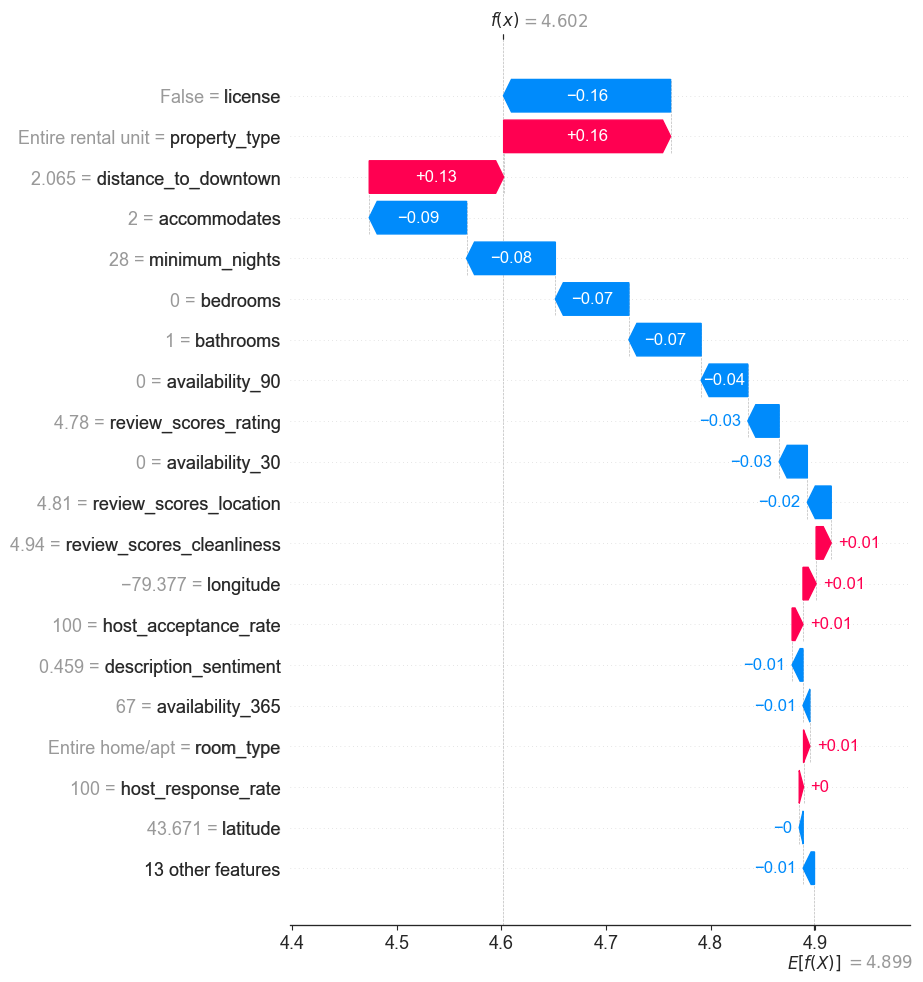

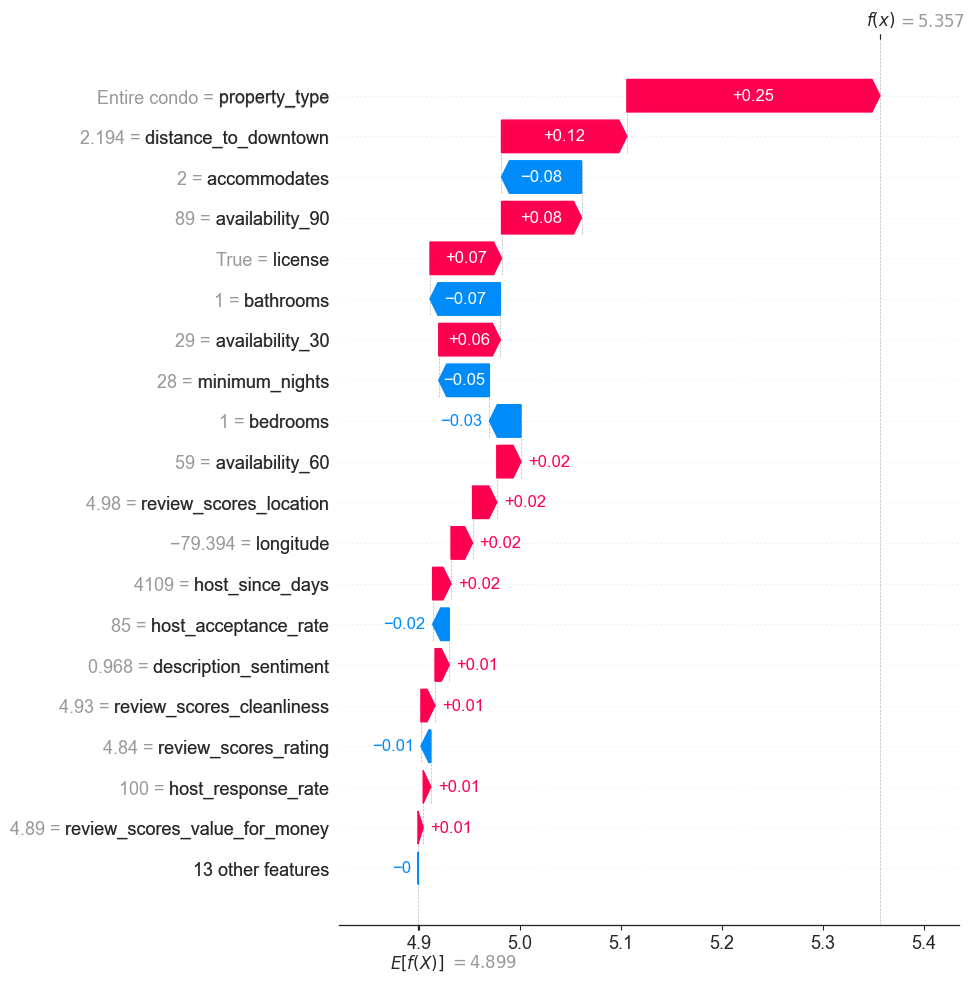

In [755]:
# SHAP values and plots for Local Interpretability of predictions with highest residuals
shap_values = XAI_SHAP(model_lgbm, test[0], 'local', 417)
shap_values = XAI_SHAP(model_lgbm, test[0], 'local', 1120)

SHAP Global Interpretation

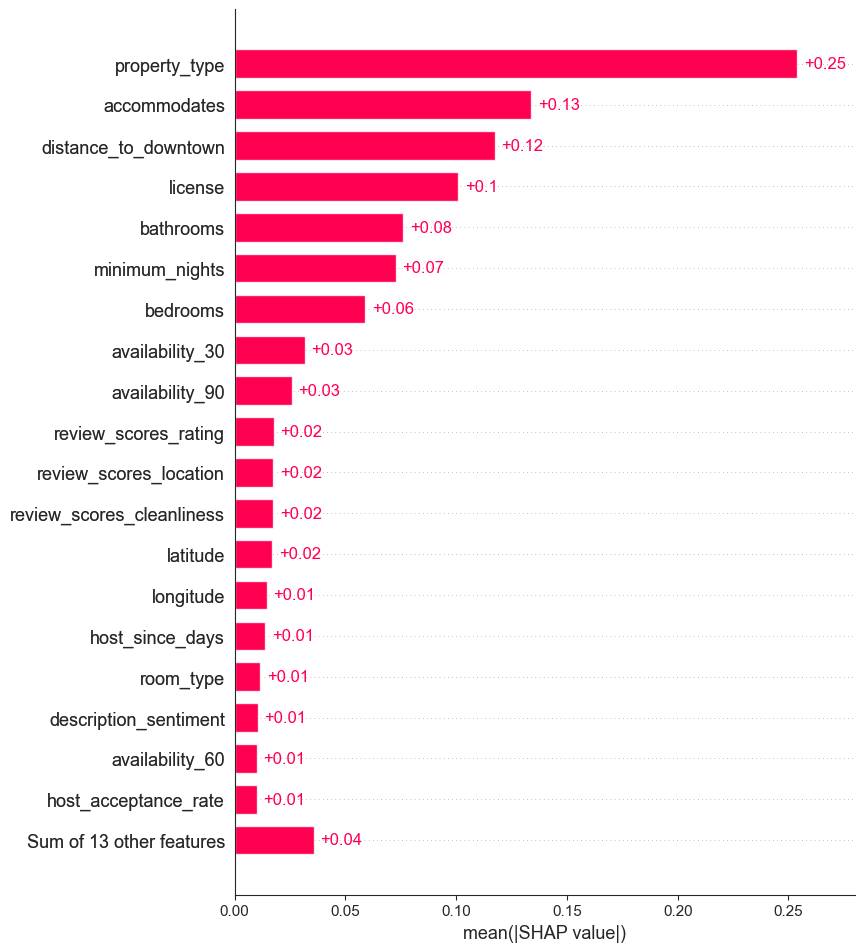

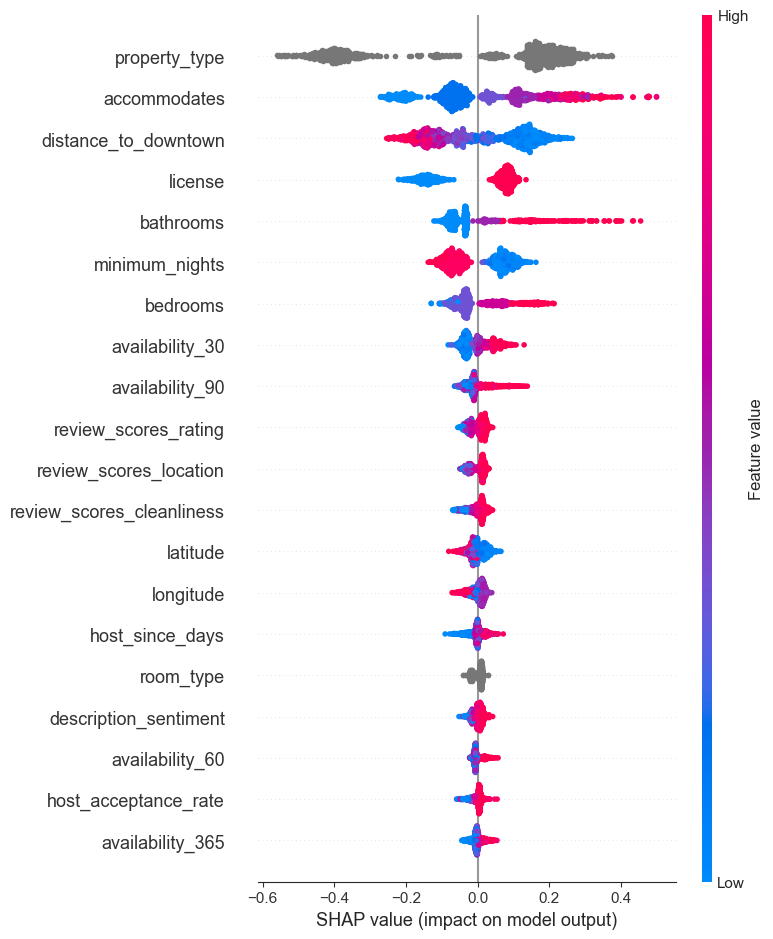

In [756]:
# SHAP values and plots for Global Interpretability
shap_values = XAI_SHAP(model_lgbm, test[0], 'global')

LGBM inbuilt feature importance

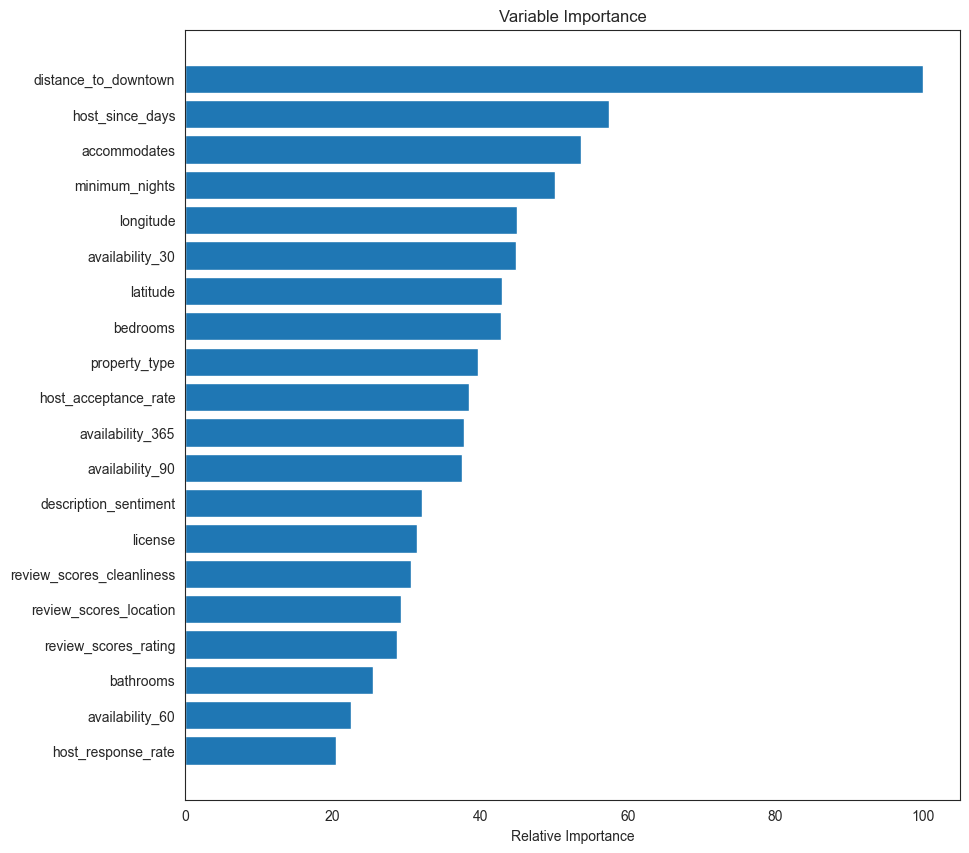

In [757]:
# Plot feature importance
top = 20
feature_importance = model_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (10,10))
plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
plt.yticks(pos[-top:], X_train_selected.columns[sorted_idx][-top:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()